# Analysis of Alamance, NC voter data and application of machine learning to predict political party affiliation

### Part 1: Imports and reading in data

The first step is to import most of the relevant libraries and read in the data from a csv file titled "ncvoter1.csv".

In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Read in the data and display
alamance_df = pd.read_csv("ncvoter1.csv")
alamance_df.head()

,county_id,county_desc,voter_reg_num,ncid,last_name,first_name,middle_name,name_suffix_lbl,status_cd,voter_status_desc,...,sanit_dist_abbrv,sanit_dist_desc,rescue_dist_abbrv,rescue_dist_desc,munic_dist_abbrv,munic_dist_desc,dist_1_abbrv,dist_1_desc,vtd_abbrv,vtd_desc
0,1,ALAMANCE,9005990,AA56273,AABEL,RUTH,EVELYN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,NaN,NaN,17.0,17TH PROSECUTORIAL,08N,08N
1,1,ALAMANCE,9178574,AA201627,AARDEN,JONI,AUTUMN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,MEB,MEBANE,17.0,17TH PROSECUTORIAL,10N,10N
2,1,ALAMANCE,9205561,AA216996,AARMSTRONG,TIMOTHY,DUANE,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,NaN,NaN,17.0,17TH PROSECUTORIAL,103,103
3,1,ALAMANCE,9048723,AA98377,AARON,CHRISTINA,CASTAGNA,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,BUR,BURLINGTON,17.0,17TH PROSECUTORIAL,03S,03S
4,1,ALAMANCE,9019674,AA69747,AARON,CLAUDIA,HAYDEN,NaN,A,ACTIVE,...,NaN,NaN,NaN,NaN,BUR,BURLINGTON,17.0,17TH PROSECUTORIAL,124,124


Here, a we have a file sourced from https://blog.splitwise.com/2014/01/06/free-us-population-density-and-unemployment-rate-by-zip-code/.

This file, "zipcode.csv", contains data for every zip code in the US, each listed with their respective population densities in units of people per square mile.

Since we want population density per zip code to be a variable we investigate, we take the data from the zipcode file and turn each zip code/population density pairing into a dictionary. This way, the densities can be mapped to the existing dataframe later on.

In [16]:
# Read in the national zipcode data
zip_df = pd.read_csv("Zipcode.csv")

# Select the columns to be the zip code and population density
zip_df = zip_df[["Zip/ZCTA", "Density Per Sq Mile"]]

# Change the dataframe into a dictionary
zip_dict = dict(zip(zip_df["Zip/ZCTA"], zip_df["Density Per Sq Mile"]))

### Part 2: Cleaning and merging the data

Below is a well-documented function that cleans the data to prepare it for machine learning.

In [18]:
# WRITE A FULL DOCSTRING FOR THIS FUNCTION
def clean_data(df, dict): # also pass in a dictionary
    # Select desired columns for analysis
    df = df[["party_cd", "birth_year", "zip_code", "race_code", "ethnic_code", "gender_code", "drivers_lic"]]

    # Remove instances without no race or heritage listed
    df = df.loc[(df['ethnic_code'] != "UN") | (df['race_code'] != "U")]
    df = df.loc[(df['ethnic_code'] != "UL") | (df['race_code'] != "U")]
    df = df.loc[(df['ethnic_code'] != "UN") | (df['race_code'] != "O")]
    df = df.loc[(df['ethnic_code'] != "UL") | (df['race_code'] != "O")]

    # Remove instances without gender
    df = df.loc[(df['gender_code'] != "U")]

    # Remove any N/A values
    df = df.dropna()

    # Remove any party voters that are unaffiliated
    df = df.loc[(df['party_cd'] != "UNA")]

    # Create a binary variable to represent if a person is a registered democrat (1 = DEM, 0 = REP/LIB)
    df['democrat'] = np.where(df['party_cd'] == "DEM", 1, 0)

    # Remove obselete party code column
    df = df.drop(columns = ['party_cd'])

    # Create a binary variable to represent sex
    df['male'] = np.where(df['gender_code'] == "M", 1, 0)

    # Remove obselete gender code column
    df = df.drop(columns = ['gender_code'])

    # Create a binary variable to represent driver's license (1 = Y, 0 = N)
    df['license'] = np.where(df['drivers_lic'] == "Y", 1, 0)

    # Remove obselete driver's license column
    df = df.drop(columns = ['drivers_lic'])

    # Create a new column to represent age based on birth year
    df['age'] = 2022 - df['birth_year']

    # Remove obselete birth year column
    df = df.drop(columns = ['birth_year'])

    # Create a new column to represent if an individual's minority status (Minority = Not White or Hispanic)
    df['minority'] = np.where((df['race_code'] != "W") | (df['ethnic_code'] == "HL"), 1, 0)

    # Remove obselete race and ethnic code columns
    df = df.drop(columns = ['race_code', 'ethnic_code'])

    # Create a new column which contains the population density per square mile for each zip code
    df['pop_density'] = df['zip_code'].map(dict)

    # Remove obselete zip code column
    df = df.drop(columns = ['zip_code'])

    return df

# Call the function on the two dataframes previously created
alamance_clean = clean_data(alamance_df, zip_dict)

# Fix the indices
alamance_clean = alamance_clean.reset_index()

# Drop the old index column
alamance_clean = alamance_clean.drop(columns = ['index'])

# Print the clean data!
alamance_clean

,democrat,male,license,age,minority,pop_density
0,0,1,0,56,0,226.223105
1,1,1,0,74,0,338.612265
2,1,0,1,56,1,623.505784
3,0,1,1,78,0,623.505784
4,0,0,1,50,0,351.969058
...,...,...,...,...,...,...
71451,0,1,1,41,0,300.021921
71452,0,0,1,73,0,338.612265
71453,0,0,1,60,0,226.223105
71454,0,1,1,61,0,226.223105


### Part 3: KNN Algorithm

The following block divides the data into testing and training sets. It also is used to find the ideal value for k in the KNN algorithm. Error rate vs k-value is plotted.

Text(0, 0.5, 'Error Rate')

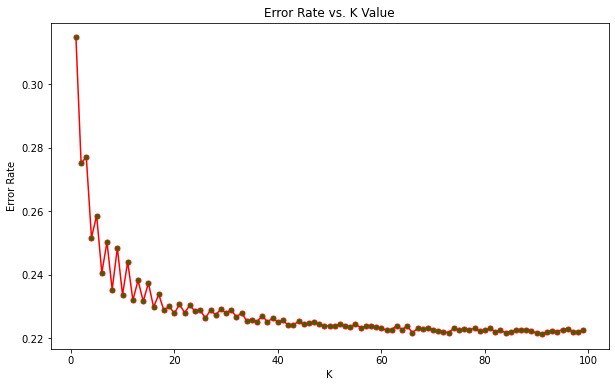

In [19]:
alamance_clean = clean_data(alamance_df, zip_dict)

# Set the independent variables to X
X = alamance_clean.drop(["democrat"], axis = 1)

# Set the dependent variable (party affiliation) to y
y = alamance_clean["democrat"]

# Preprocess and normalize the data for ML
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

# Split into testing and training sets. Since this is a large dataset, it is appropriate to divide into 80-20 training-testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
error_rate = []
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# Plot the error rate vs K value
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='red', marker='o',markerfacecolor='green', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')


Using the elbow method -- choosing a value for k where the graph starts to converge -- we decided on a k-value of 39. Also, we chose an odd number so as to break ties. The accuracy of the KNN algorithm with a k-value of 39 is printed.

In [20]:
# Create and test the accuracy of the KNN algoritm with k = 39.
# Selected k value by the elbow method, also picked odd number.
alamance_knn = KNeighborsClassifier(n_neighbors = 39)
alamance_knn.fit(X_train, y_train)
print("Accuracy Score: ", alamance_knn.score(X_test, y_test))

Accuracy Score:  0.7736495941785614


### Part 4: Correlation Matrix

Before proceeding any further, in order to make sure our data is suitable for machine learning, we created a correlation heatmap. Low correlations between variables means that they are good to use for machine learning. All of our chosen variables displayed very low correlations with each other.

<AxesSubplot:>

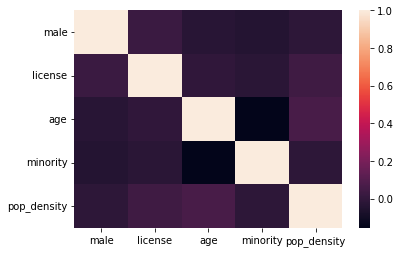

In [21]:
# More imports
import seaborn as sns

# Create a correlation matrix between all of the attributes besides the political party affiliation
alamance_corr = alamance_clean.drop(["democrat"], axis = 1).corr()

# Create a correlation heatmap of the correlation matrix
sns.heatmap(alamance_corr)

### Part 5: Support Vector Machine

Below is the code for running a support vector machine with a linear kernel on our testing and training sets. The accuracy is printed below.

In [22]:
# More imports
from sklearn import svm
from sklearn import metrics

# Create the support vector machine classifier
alamance_svm = svm.SVC(kernel = 'linear')

# Fit the model using the training sets
alamance_svm.fit(X_train, y_train)

# See what the testing set predicts
y_pred = alamance_svm.predict(X_test)

# Print out the accuracy score of the model
print("Accuracy Score: ", metrics.accuracy_score(y_test, y_pred))

Accuracy Score:  0.7734396865379233


### Part 6: Logistic Regression

Below is the code for running a logistic regression on our testing and training sets. The accuracy is printed below.

In [23]:
# More imports
from sklearn import linear_model

alamance_lr = linear_model.LogisticRegression()
alamance_lr.fit(X_train, y_train)

y_pred = alamance_lr.predict(X_test)

print("Accuracy Score: ", metrics.accuracy_score(y_test, y_pred))

Accuracy Score:  0.7730198712566471


We have concluded that since it has the highest accuracy, the KNN algorithm is best suited for predicting political party affiliation in Alamance. Roughly 77% of the time, the algorithm will correctly predict someone's affiliation.


### Part 7: Testing ourselves and celebrities

As a fun activity, we have put our demographic information, plus some celebrities, into a dataframe to have the KNN algorithm predict what our party affiliation will be. The population density column was taken from each person's hometown. We understand that this is likely not accurate, since we have trained our data only on Alamance, NC, but it is more of a proof-of-concept for our data and algorithm.

In [24]:
# Column names
cols = ['name', 'male', 'license', 'age', 'minority', 'pop_density']

# Group members
adam = ['Adam Amer', 1, 1, 21, 0, 1568.173963]
will = ['William Leung', 1, 1, 19, 1, 49171.80617]
sean = ["Sean O'Grady", 1, 1, 21, 1, 76.07466716]

# Celebrities
mark_zuckerberg = ['Mark Zuckerberg', 1, 1, 38, 0, 27.95259355]
melinda_gates = ['Melinda Gates', 0, 1, 58, 0, 3727.871674]
susan_wojcicki = ['Susan Wojcicki', 0, 1, 54, 0, 6807.466363]
donald_trump = ['Donald Trump', 1, 1, 76, 0, 72918]
joe_biden = ['Joe Biden', 1, 1, 80, 0, 10984]

# Create a pandas dataframe of all of the people
test_data = [adam, will, sean, mark_zuckerberg, melinda_gates, susan_wojcicki, donald_trump, joe_biden]
people_df = pd.DataFrame(test_data)

# Set column names
people_df.columns = cols

people_df


,name,male,license,age,minority,pop_density
0,Adam Amer,1,1,21,0,1568.173963
1,William Leung,1,1,19,1,49171.806170
2,Sean O'Grady,1,1,21,1,76.074667
3,Mark Zuckerberg,1,1,38,0,27.952594
4,Melinda Gates,0,1,58,0,3727.871674
5,Susan Wojcicki,0,1,54,0,6807.466363
6,Donald Trump,1,1,76,0,72918.000000
7,Joe Biden,1,1,80,0,10984.000000


In [25]:
# Drop the names column temporarily
people_df_nameless = people_df.drop(columns = ['name'])

# Predict the affiliation of each person using the KNN algoritm
predicted = alamance_knn.predict(people_df_nameless)

# Add the party affiliation column to the dataframe
people_df['democrat'] = predicted

people_df

C:\Users\asqua\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,name,male,license,age,minority,pop_density,democrat
0,Adam Amer,1,1,21,0,1568.173963,1
1,William Leung,1,1,19,1,49171.806170,1
2,Sean O'Grady,1,1,21,1,76.074667,1
3,Mark Zuckerberg,1,1,38,0,27.952594,0
4,Melinda Gates,0,1,58,0,3727.871674,1
5,Susan Wojcicki,0,1,54,0,6807.466363,1
6,Donald Trump,1,1,76,0,72918.000000,1
7,Joe Biden,1,1,80,0,10984.000000,1
